# Cytnx tutorial on colab
See https://cytnx-dev.github.io/Cytnx_doc/v1.0.0/index.html for more information of the Cytnx library

Install `conda` on `colab` and install `Cytnx`. (it needs around 2 minutes.)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [2]:
%%bash
conda init
conda config --add channels conda-forge
conda create --channel conda-forge --name cytnx python=3.11 _openmp_mutex=*=*_llvm
conda activate cytnx
conda install -c kaihsinwu cytnx

no change     /usr/local/condabin/conda
no change     /usr/local/bin/conda
no change     /usr/local/bin/conda-env
no change     /usr/local/bin/activate
no change     /usr/local/bin/deactivate
no change     /usr/local/etc/profile.d/conda.sh
no change     /usr/local/etc/fish/conf.d/conda.fish
no change     /usr/local/shell/condabin/Conda.psm1
no change     /usr/local/shell/condabin/conda-hook.ps1
no change     /usr/local/lib/python3.11/site-packages/xontrib/conda.xsh
no change     /usr/local/etc/profile.d/conda.csh
no change     /root/.bashrc
No action taken.
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/cytnx

  added / updated specs:
    - _openmp_mutex[build=*_llvm]
    - python=3.11


The following NEW packages will be INSTALLED:

  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-3_kmp_llvm 
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h4bc722e_7 
  ca-certificates 



==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



CondaError: Run 'conda init' before 'conda activate'



==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda




### Test whther install suscessfully.

In [3]:
import cytnx
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/site-packages/cytnx/__init__.py:14: UserWarning: numpy and/or scipy are imported before cytnx. Please make sure it support ILP64.
  warnings.warn("numpy and/or scipy are imported before cytnx. Please make sure it support ILP64.")


In [4]:
# test
print('cytnx version:', cytnx.__version__)
A = cytnx.ones(4)
print(A)

cytnx version: 1.0.0

Total elem: 4
type  : Double (Float64)
cytnx device: CPU
Shape : (4)
[1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00 ]





# Density matrix renormalization group (DMRG) tutorial

## 1. Define the matrix product operator (MPO) for the Hamiltonian

### 1.1 Define operators

#### $$ \hat{S}^{+}=\left[\begin{array}{cc}
0 & 1\\
0 & 0
\end{array}\right]
, \qquad
\hat{S}^{-}=\left[\begin{array}{cc}
0 & 0\\
1 & 0
\end{array}\right]$$
#### $$ \hat{S}^{z}=\frac{1}{2}\left[\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}\right]
, \qquad
\hat{S}^{x}=\frac{1}{2}\left[\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}\right]
, \qquad
\hat{I}=\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
$$

<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/szsx.png?raw=1" alt="drawing" width="300"/>

In [5]:
Nsites = 20 # Number of sites
chi = 32 # MPS bond dimension
d = 2 #physical dimension
s = 0.5 #spin-half

sx = cytnx.physics.spin(0.5,'x')
sy = cytnx.physics.spin(0.5,'y')
sp = sx+1j*sy
sm = sx-1j*sy
eye = cytnx.eye(d)


### 1.2 Define Hamiltonian MPO

#### XX model
#### MPO tensor
#### $$\hat{H} = L_0 M_1 M_2 \cdots M_N R_0,$$
#### $$
L_{0}=\left[\begin{array}{ccc}
0 & 0 & 1\end{array}\right]
, \qquad
M_i=\left[\begin{array}{ccc}
\hat{I_i}& \sqrt{2} \hat{S}^{+}_i & \sqrt{2} \hat{S}^{-}_i & 0\\
0 & 0 & 0&\sqrt{2} \hat{S}^{-}_i\\
0 & 0& 0 & \sqrt{2} \hat{S}^{+}_i\\
0 & 0& 0 & \hat{I_i}
\end{array}\right]
, \qquad
R_{0}=\left[\begin{array}{c}
1\\
0\\
0
\end{array}\right]
$$

<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/mpo.png?raw=1" alt="drawing" width="600"/>

In [6]:
M = cytnx.zeros([4, 4, d, d])
M[0,0] = M[3,3] = eye
M[0,1] = M[2,3] = 2**0.5*sp.real()
M[0,2] = M[1,3] = 2**0.5*sm.real()
M = cytnx.UniTensor(M,0)

L0 = cytnx.UniTensor(cytnx.zeros([4,1,1]), rowrank = 0) #Left boundary
R0 = cytnx.UniTensor(cytnx.zeros([4,1,1]), rowrank = 0) #Right boundarM = y
L0[0,0,0] = 1.; R0[3,0,0] = 1.

## 2. Initialize MPS

### 2.1 Initialize MPS as a random state


<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/mps.png?raw=1" alt="drawing" width="450"/>

In [7]:
# Initialize MPS as a product state
lbls = [] # List for storing the MPS labels
A = [None for i in range(Nsites)]
A[0] = cytnx.UniTensor(cytnx.random.normal([1, d, min(chi, d)], 0., 1.), rowrank = 2)
A[0].relabels_(["0","1","2"])
lbls.append(["0","1","2"]) # store the labels for later convinience.

for k in range(1,Nsites):
    dim1 = A[k-1].shape()[2]; dim2 = d
    dim3 = min(min(chi, A[k-1].shape()[2] * d), d ** (Nsites - k - 1))
    A[k] = cytnx.UniTensor(cytnx.random.normal([dim1, dim2, dim3],0.,1.), rowrank = 2)

    lbl = [str(2*k),str(2*k+1),str(2*k+2)]
    A[k].relabels_(lbl)
    lbls.append(lbl) # store the labels for later convinience.



## 3. Define the effective Hamiltonian

### 3.1 Compute the environment tensors LR, and make the MPS **left orthogonal**

<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/leftotho.png?raw=1" alt="drawing" width="700"/>
<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/envcontract.png?raw=1" alt="drawing" width="400"/>

In [8]:
#LR[0]:        LR[1]:            LR[2]:
#
#   -----      -----A[0]---     -----A[1]---
#   |          |     |          |     |
#  ML----     LR[0]--M-----    LR[1]--M-----      ......
#   |          |     |          |     |
#   -----      -----A*[0]--     -----A*[1]--
#
#
LR = [None for i in range(Nsites+1)]
LR[0]  = L0
LR[-1] = R0
for p in range(Nsites - 1):

    ## Changing to canonical form site by site:
    s, A[p] ,vt = cytnx.linalg.Gesvd(A[p])
    A[p+1] = cytnx.Contract(cytnx.Contract(s,vt),A[p+1])

    ## Calculate enviroments:
    anet = cytnx.Network()
    anet.FromString(["L: -2,-1,-3",\
                        "A: -1,-4,1",\
                        "M: -2,0,-4,-5",\
                        "A_Conj: -3,-5,2",\
                        "TOUT: 0,1,2"])
    # or you can do: anet = cytnx.Network("L_AMAH.net")
    anet.PutUniTensors(["L","A","A_Conj","M"],[LR[p],A[p],A[p].Conj(),M])
    LR[p+1] = anet.Launch()

    # Recover the original MPS labels
    A[p].relabels_(lbls[p])
    A[p+1].relabels_(lbls[p+1])

_,A[-1] = cytnx.linalg.Gesvd(A[-1],is_U=True,is_vT=False) ## last one.
A[-1].relabels_(lbls[-1]) # Recover the original MPS labels


-------- start of print ---------
Tensor name: 
is_diag    : False
contiguous : True

Total elem: 4
type  : Double (Float64)
cytnx device: CPU
Shape : (2,2,1)
[[[-4.68611e-01 ]
  [-4.24343e-01 ]]
 [[-4.93490e-01 ]
  [5.97332e-01 ]]]





### 3.2 Define effective Hamiltonian and $\hat{H}|\psi\rangle$ operation

<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/heff.png?raw=1" alt="drawing" width="600"/>

In [9]:
# An effective Hamiltonian must:
# 1. Inherit <cytnx.LinOp> class
# 2. Has a function <matvec> that implements H|psi> operation

class Hxx(cytnx.LinOp):

    def __init__(self, anet, psidim):
        cytnx.LinOp.__init__(self,"mv", psidim, cytnx.Type.Double, cytnx.Device.cpu)
        self.anet = anet

    def matvec(self, v):
        lbl = v.labels()
        self.anet.PutUniTensor("psi",v)
        out = self.anet.Launch()
        out.relabels_(lbl)
        return out

## 4. Find the ground state by DMRG

### 4.1 DMRG algorithm

<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/dmrg_sweep.png?raw=1" alt="drawing" width="600"/>
<img src="https://github.com/Cytnx-dev/Cytnx_colab_tutorial/blob/main/figures/twositecontract.png?raw=1" alt="drawing" width="650"/>

In [10]:
def dmrg_XXmodel_dense(Nsites, chi, numsweeps, maxit):
    class Hxx(cytnx.LinOp):

        def __init__(self, anet, psidim):
            cytnx.LinOp.__init__(self,"mv", psidim, cytnx.Type.Double, cytnx.Device.cpu)
            self.anet = anet

        def matvec(self, v):
            lbl = v.labels()
            self.anet.PutUniTensor("psi",v)
            out = self.anet.Launch()
            out.relabels_(lbl)
            return out

    def optimize_psi(psi, functArgs, maxit=2, krydim=4):

        L,M1,M2,R = functArgs
        anet = cytnx.Network()
        anet.FromString(["psi: -1,-2,-3,-4",\
                        "L: -5,-1,0",\
                        "R: -7,-4,3",\
                        "M1: -5,-6,-2,1",\
                        "M2: -6,-7,-3,2",\
                        "TOUT: 0,1;2,3"])
        # or you can do : anet = cytnx.Network("projector.net")
        anet.PutUniTensors(["L","M1","M2","R"],[L,M1,M2,R])

        H = Hxx(anet, psi.shape()[0]*psi.shape()[1]*psi.shape()[2]*psi.shape()[3])
        energy, psivec = cytnx.linalg.Lanczos(Hop = H, method = "Gnd", Maxiter = 4, CvgCrit = 9999999999, Tin = psi)

        return psivec, energy[0].item()
    Ekeep = []
    for k in range(1, numsweeps+1):

        for p in range(Nsites-2,-1,-1):
            dim_l = A[p].shape()[0]
            dim_r = A[p+1].shape()[2]
            new_dim = min(dim_l*d,dim_r*d,chi)

            psi = cytnx.Contract(A[p],A[p+1]) # contract
            psi, Entemp = optimize_psi(psi, (LR[p],M,M,LR[p+2]), maxit)
            Ekeep.append(Entemp)

            psi.set_rowrank_(2) # maintain rowrank to perform the svd
            s,A[p],A[p+1] = cytnx.linalg.Svd_truncate(psi,new_dim)
            A[p+1].relabels_(lbls[p+1]); # set the label back to be consistent

            s = s/s.Norm().item() # normalize s

            A[p] = cytnx.Contract(A[p],s) # absorb s into next neighbor
            A[p].relabels_(lbls[p]); # set the label back to be consistent

            # update LR from right to left:
            anet = cytnx.Network()
            anet.FromString(["R: -2,-1,-3",\
                            "B: 1,-4,-1",\
                            "M: 0,-2,-4,-5",\
                            "B_Conj: 2,-5,-3",\
                            "TOUT: 0;1,2"])
            # or you can do: anet = cytnx.Network("R_AMAH.net")
            anet.PutUniTensors(["R","B","M","B_Conj"],[LR[p+2],A[p+1],M,A[p+1].Conj()])
            LR[p+1] = anet.Launch()

            print('Sweep[r->l]: %d/%d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))

        A[0].set_rowrank_(1)
        _,A[0] = cytnx.linalg.Gesvd(A[0],is_U=False, is_vT=True)
        A[0].relabels_(lbls[0]); #set the label back to be consistent

        for p in range(Nsites-1):
            dim_l = A[p].shape()[0]
            dim_r = A[p+1].shape()[2]
            new_dim = min(dim_l*d,dim_r*d,chi)

            psi = cytnx.Contract(A[p],A[p+1]) ## contract
            psi, Entemp = optimize_psi(psi, (LR[p],M,M,LR[p+2]), maxit)
            Ekeep.append(Entemp)

            psi.set_rowrank_(2) # maintain rowrank to perform the svd
            s,A[p],A[p+1] = cytnx.linalg.Svd_truncate(psi,new_dim)
            A[p].relabels_(lbls[p]); #set the label back to be consistent

            s = s/s.Norm().item() # normalize s

            A[p+1] = cytnx.Contract(s,A[p+1]) ## absorb s into next neighbor.
            A[p+1].relabels_(lbls[p+1]); #set the label back to be consistent

            # update LR from left to right:
            anet = cytnx.Network()
            anet.FromString(["L: -2,-1,-3",\
                            "A: -1,-4,1",\
                            "M: -2,0,-4,-5",\
                            "A_Conj: -3,-5,2",\
                            "TOUT: 0,1,2"])
            # or you can do: anet = cytnx.Network("L_AMAH.net")

            anet.PutUniTensors(["L","A","A_Conj","M"],[LR[p],A[p],A[p].Conj(),M])
            LR[p+1] = anet.Launch()

            print('Sweep[l->r]: %d/%d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))

        A[-1].set_rowrank_(2)
        _,A[-1] = cytnx.linalg.Gesvd(A[-1],is_U=True,is_vT=False) ## last one.
        A[-1].relabels_(lbls[-1]); #set the label back to be consistent
    return Ekeep




In [11]:
numsweeps = 6 # number of DMRG sweeps
maxit = 2 # iterations of Lanczos method

Es = dmrg_XXmodel_dense(Nsites, chi, numsweeps, maxit)

#### Compare with exact results (computed from free fermions)
from numpy import linalg as LA
# import matplotlib.pyplot as plt
H = np.diag(np.ones(Nsites-1),k=1) + np.diag(np.ones(Nsites-1),k=-1)
D = LA.eigvalsh(H)
EnExact = 2*sum(D[D < 0])

print("Energy error = ", np.abs(Es[-1]-EnExact))

Sweep[r->l]: 1/6, Loc: 18,Energy: -2.178628
Sweep[r->l]: 1/6, Loc: 17,Energy: -3.459418
Sweep[r->l]: 1/6, Loc: 16,Energy: -4.812453
Sweep[r->l]: 1/6, Loc: 15,Energy: -6.351529
Sweep[r->l]: 1/6, Loc: 14,Energy: -7.597602
Sweep[r->l]: 1/6, Loc: 13,Energy: -8.736482
Sweep[r->l]: 1/6, Loc: 12,Energy: -9.869680
Sweep[r->l]: 1/6, Loc: 11,Energy: -10.950589
Sweep[r->l]: 1/6, Loc: 10,Energy: -11.959949
Sweep[r->l]: 1/6, Loc: 9,Energy: -13.006915
Sweep[r->l]: 1/6, Loc: 8,Energy: -14.088517
Sweep[r->l]: 1/6, Loc: 7,Energy: -15.233556
Sweep[r->l]: 1/6, Loc: 6,Energy: -16.364473
Sweep[r->l]: 1/6, Loc: 5,Energy: -17.763217
Sweep[r->l]: 1/6, Loc: 4,Energy: -18.875550
Sweep[r->l]: 1/6, Loc: 3,Energy: -19.769350
Sweep[r->l]: 1/6, Loc: 2,Energy: -20.412847
Sweep[r->l]: 1/6, Loc: 1,Energy: -20.862780
Sweep[r->l]: 1/6, Loc: 0,Energy: -21.027463
Sweep[l->r]: 1/6, Loc: 0,Energy: -21.106181
Sweep[l->r]: 1/6, Loc: 1,Energy: -21.351416
Sweep[l->r]: 1/6, Loc: 2,Energy: -21.680443
Sweep[l->r]: 1/6, Loc: 3,Energ

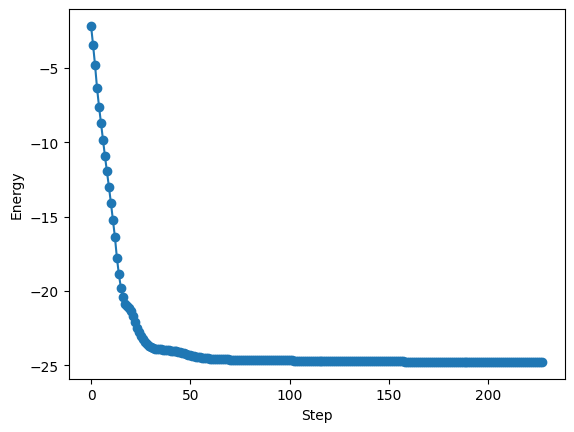

In [12]:
plt.plot(Es, marker = 'o')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.show()

## Try yourself:
Find the ground state energy of the **antiferromagnet Heisenberg model** given by the Hamiltonian:

$$\hat{H} = \sum_{i=1}^{N-1} \hat{S}^x_i\hat{S}^x_{i+1} + \hat{S}^y_i\hat{S}^y_{i+1} + \hat{S}^z_i\hat{S}^z_{i+1}$$

Please try several values of $N$ and **extraplolated** to $N \to \infty$ and compare to the exact value at **thermaldynamic limit**:
$$1/4 - log(2) \approx -0.4431$$

## Whole DMRG implementation

In [13]:
import sys,os
import numpy as np
import cytnx

"""
Reference: https://www.tensors.net
Author: Yu-Hsueh Chen, Kai-Hsin Wu, Ke Hsu (j9263178)
"""

def dmrg_XXmodel_dense(Nsites, chi, numsweeps, maxit):
    class Hxx(cytnx.LinOp):

        def __init__(self, anet, psidim):
            cytnx.LinOp.__init__(self,"mv", psidim, cytnx.Type.Double, cytnx.Device.cpu)
            self.anet = anet

        def matvec(self, v):
            lbl = v.labels()
            self.anet.PutUniTensor("psi",v)
            out = self.anet.Launch()
            out.relabels_(lbl)
            return out

    def optimize_psi(psi, functArgs, maxit=2, krydim=4):

        L,M1,M2,R = functArgs
        anet = cytnx.Network()
        anet.FromString(["psi: -1,-2,-3,-4",\
                        "L: -5,-1,0",\
                        "R: -7,-4,3",\
                        "M1: -5,-6,-2,1",\
                        "M2: -6,-7,-3,2",\
                        "TOUT: 0,1;2,3"])
        # or you can do : anet = cytnx.Network("projector.net")
        anet.PutUniTensors(["L","M1","M2","R"],[L,M1,M2,R])

        H = Hxx(anet, psi.shape()[0]*psi.shape()[1]*psi.shape()[2]*psi.shape()[3])
        energy, psivec = cytnx.linalg.Lanczos(Hop = H, method = "Gnd", Maxiter = 4, CvgCrit = 9999999999, Tin = psi)

        return psivec, energy[0].item()

    d = 2 #physical dimension
    s = 0.5 #spin-half

    sx = cytnx.physics.spin(0.5,'x')
    sy = cytnx.physics.spin(0.5,'y')
    sp = sx+1j*sy
    sm = sx-1j*sy

    eye = cytnx.eye(d)
    M = cytnx.zeros([4, 4, d, d])
    M[0,0] = M[3,3] = eye
    M[0,1] = M[2,3] = 2**0.5*sp.real()
    M[0,2] = M[1,3] = 2**0.5*sm.real()
    M = cytnx.UniTensor(M,0)

    L0 = cytnx.UniTensor(cytnx.zeros([4,1,1]), rowrank = 0) #Left boundary
    R0 = cytnx.UniTensor(cytnx.zeros([4,1,1]), rowrank = 0) #Right boundary
    L0[0,0,0] = 1.; R0[3,0,0] = 1.

    lbls = [] # List for storing the MPS labels
    A = [None for i in range(Nsites)]
    A[0] = cytnx.UniTensor(cytnx.random.normal([1, d, min(chi, d)], 0., 1.), rowrank = 2)
    A[0].relabels_(["0","1","2"])
    lbls.append(["0","1","2"]) # store the labels for later convinience.

    for k in range(1,Nsites):
        dim1 = A[k-1].shape()[2]; dim2 = d
        dim3 = min(min(chi, A[k-1].shape()[2] * d), d ** (Nsites - k - 1))
        A[k] = cytnx.UniTensor(cytnx.random.normal([dim1, dim2, dim3],0.,1.), rowrank = 2)

        lbl = [str(2*k),str(2*k+1),str(2*k+2)]
        A[k].relabels_(lbl)
        lbls.append(lbl) # store the labels for later convinience.

    LR = [None for i in range(Nsites+1)]
    LR[0]  = L0
    LR[-1] = R0


    for p in range(Nsites - 1):

        ## Changing to canonical form site by site:
        s, A[p] ,vt = cytnx.linalg.Gesvd(A[p])
        A[p+1] = cytnx.Contract(cytnx.Contract(s,vt),A[p+1])

        ## Calculate enviroments:
        anet = cytnx.Network()
        anet.FromString(["L: -2,-1,-3",\
                        "A: -1,-4,1",\
                        "M: -2,0,-4,-5",\
                        "A_Conj: -3,-5,2",\
                        "TOUT: 0,1,2"])
        # or you can do: anet = cytnx.Network("L_AMAH.net")
        anet.PutUniTensors(["L","A","A_Conj","M"],[LR[p],A[p],A[p].Conj(),M])
        LR[p+1] = anet.Launch()

        # Recover the original MPS labels
        A[p].relabels_(lbls[p])
        A[p+1].relabels_(lbls[p+1])

    _,A[-1] = cytnx.linalg.Gesvd(A[-1],is_U=True,is_vT=False) ## last one.
    A[-1].relabels_(lbls[-1]) # Recover the original MPS labels

    Ekeep = []
    for k in range(1, numsweeps+1):

        for p in range(Nsites-2,-1,-1):
            dim_l = A[p].shape()[0]
            dim_r = A[p+1].shape()[2]
            new_dim = min(dim_l*d,dim_r*d,chi)

            psi = cytnx.Contract(A[p],A[p+1]) # contract
            psi, Entemp = optimize_psi(psi, (LR[p],M,M,LR[p+2]), maxit)
            Ekeep.append(Entemp)

            psi.set_rowrank_(2) # maintain rowrank to perform the svd
            s,A[p],A[p+1] = cytnx.linalg.Svd_truncate(psi,new_dim)
            A[p+1].relabels_(lbls[p+1]); # set the label back to be consistent

            s = s/s.Norm().item() # normalize s

            A[p] = cytnx.Contract(A[p],s) # absorb s into next neighbor
            A[p].relabels_(lbls[p]); # set the label back to be consistent

            # update LR from right to left:
            anet = cytnx.Network()
            anet.FromString(["R: -2,-1,-3",\
                            "B: 1,-4,-1",\
                            "M: 0,-2,-4,-5",\
                            "B_Conj: 2,-5,-3",\
                            "TOUT: 0;1,2"])
            # or you can do: anet = cytnx.Network("R_AMAH.net")
            anet.PutUniTensors(["R","B","M","B_Conj"],[LR[p+2],A[p+1],M,A[p+1].Conj()])
            LR[p+1] = anet.Launch()

            print('Sweep[r->l]: %d/%d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))

        A[0].set_rowrank_(1)
        _,A[0] = cytnx.linalg.Gesvd(A[0],is_U=False, is_vT=True)
        A[0].relabels_(lbls[0]); #set the label back to be consistent

        for p in range(Nsites-1):
            dim_l = A[p].shape()[0]
            dim_r = A[p+1].shape()[2]
            new_dim = min(dim_l*d,dim_r*d,chi)

            psi = cytnx.Contract(A[p],A[p+1]) ## contract
            psi, Entemp = optimize_psi(psi, (LR[p],M,M,LR[p+2]), maxit)
            Ekeep.append(Entemp)

            psi.set_rowrank_(2) # maintain rowrank to perform the svd
            s,A[p],A[p+1] = cytnx.linalg.Svd_truncate(psi,new_dim)
            A[p].relabels_(lbls[p]); #set the label back to be consistent

            s = s/s.Norm().item() # normalize s

            A[p+1] = cytnx.Contract(s,A[p+1]) ## absorb s into next neighbor.
            A[p+1].relabels_(lbls[p+1]); #set the label back to be consistent

            # update LR from left to right:
            anet = cytnx.Network()
            anet.FromString(["L: -2,-1,-3",\
                            "A: -1,-4,1",\
                            "M: -2,0,-4,-5",\
                            "A_Conj: -3,-5,2",\
                            "TOUT: 0,1,2"])
            # or you can do: anet = cytnx.Network("L_AMAH.net")

            anet.PutUniTensors(["L","A","A_Conj","M"],[LR[p],A[p],A[p].Conj(),M])
            LR[p+1] = anet.Launch()

            print('Sweep[l->r]: %d/%d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))

        A[-1].set_rowrank_(2)
        _,A[-1] = cytnx.linalg.Gesvd(A[-1],is_U=True,is_vT=False) ## last one.
        A[-1].relabels_(lbls[-1]); #set the label back to be consistent
    return Ekeep

if __name__ == '__main__':


    Nsites = 20 # Number of sites
    chi = 32 # MPS bond dimension
    numsweeps = 6 # number of DMRG sweeps
    maxit = 2 # iterations of Lanczos method

    Es = dmrg_XXmodel_dense(Nsites, chi, numsweeps, maxit)

    #### Compare with exact results (computed from free fermions)
    from numpy import linalg as LA
    # import matplotlib.pyplot as plt
    H = np.diag(np.ones(Nsites-1),k=1) + np.diag(np.ones(Nsites-1),k=-1)
    D = LA.eigvalsh(H)
    EnExact = 2*sum(D[D < 0])

    print("Energy error = ", np.abs(Es[-1]-EnExact))

Sweep[r->l]: 1/6, Loc: 18,Energy: -3.049904
Sweep[r->l]: 1/6, Loc: 17,Energy: -4.054075
Sweep[r->l]: 1/6, Loc: 16,Energy: -5.648174
Sweep[r->l]: 1/6, Loc: 15,Energy: -7.228176
Sweep[r->l]: 1/6, Loc: 14,Energy: -8.422210
Sweep[r->l]: 1/6, Loc: 13,Energy: -9.549307
Sweep[r->l]: 1/6, Loc: 12,Energy: -10.687786
Sweep[r->l]: 1/6, Loc: 11,Energy: -11.829832
Sweep[r->l]: 1/6, Loc: 10,Energy: -13.068334
Sweep[r->l]: 1/6, Loc: 9,Energy: -14.268435
Sweep[r->l]: 1/6, Loc: 8,Energy: -15.372540
Sweep[r->l]: 1/6, Loc: 7,Energy: -16.566034
Sweep[r->l]: 1/6, Loc: 6,Energy: -17.546783
Sweep[r->l]: 1/6, Loc: 5,Energy: -18.380150
Sweep[r->l]: 1/6, Loc: 4,Energy: -19.005926
Sweep[r->l]: 1/6, Loc: 3,Energy: -19.505699
Sweep[r->l]: 1/6, Loc: 2,Energy: -19.892491
Sweep[r->l]: 1/6, Loc: 1,Energy: -20.157377
Sweep[r->l]: 1/6, Loc: 0,Energy: -20.239379
Sweep[l->r]: 1/6, Loc: 0,Energy: -20.284267
Sweep[l->r]: 1/6, Loc: 1,Energy: -20.464840
Sweep[l->r]: 1/6, Loc: 2,Energy: -20.726761
Sweep[l->r]: 1/6, Loc: 3,Ener

## TDVP

In [14]:
import sys,os
import numpy as np
import cytnx

"""
Author: Hao-Ti Hung
"""

def tdvp1_XXZmodel_dense(J, Jz, hx, hz, A, chi, dt, time_step):

    class OneSiteOp(cytnx.LinOp):
        def __init__(self, L, M, R):
            self.anet = cytnx.Network()
            d = L.shape()[0]
            D1 = L.shape()[2]
            D2 = R.shape()[2]
            cytnx.LinOp.__init__(self, "mv", D1*D2*d, L.dtype(), R.device())
            self.anet.FromString([\
                        "psi: -1,-2,-3",\
                        "L: -4,-1,0",\
                        "R: -6,-3,2",\
                        "M: -4,-6,-2,1",\
                        "TOUT: 0,1;2"])
            self.anet.PutUniTensors(["L","M","R"],[L,M,R])
        def matvec(self, v):
            self.anet.PutUniTensor("psi",v)
            out = self.anet.Launch()
            out.relabels_(v.labels())
            return out

    class ZeroSiteOp(cytnx.LinOp):
        def __init__(self, L, R):
            self.anet = cytnx.Network()
            d = L.shape()[0]
            D1 = L.shape()[2]
            D2 = R.shape()[2]
            cytnx.LinOp.__init__(self, "mv", D1*D2, L.dtype(), R.device())
            self.anet.FromString([\
                        "C: -1,-2",\
                        "L: -3,-1,0",\
                        "R: -3,-2,1",\
                        "TOUT: 0;1"])
            self.anet.PutUniTensors(["L","R"],[L,R])
        def matvec(self, v):
            self.anet.PutUniTensor("C",v)
            out = self.anet.Launch()
            out.relabels_(v.labels())
            return out

    def time_evolve_Lan_f(psi, functArgs, delta):
        L,M,R = functArgs
        L = L.astype(cytnx.Type.ComplexDouble)
        M = M.astype(cytnx.Type.ComplexDouble)
        R = R.astype(cytnx.Type.ComplexDouble)
        op = OneSiteOp(L,M,R)
        exp_iH_v = cytnx.linalg.Lanczos_Exp(op, psi, -1.0j*delta*0.5, 1.0e-8)
        exp_iH_v.relabels_(psi.labels())
        return exp_iH_v

    def time_evolve_Lan_b(psi, functArgs, delta):
        L,R = functArgs
        L = L.astype(cytnx.Type.ComplexDouble)
        R = R.astype(cytnx.Type.ComplexDouble)
        op = ZeroSiteOp(L,R)
        exp_iH_v = cytnx.linalg.Lanczos_Exp(op, psi, 1.0j*delta*0.5, 1.0e-8)
        exp_iH_v.relabels_(psi.labels())
        return exp_iH_v

    def get_energy(A, M):
        N = len(A)
        L0 = cytnx.UniTensor(cytnx.zeros([5,1,1]), rowrank = 0) #Left boundary
        R0 = cytnx.UniTensor(cytnx.zeros([5,1,1]), rowrank = 0) #Right boundary
        L0[0,0,0] = 1.; R0[4,0,0] = 1.
        L = L0
        anet = cytnx.Network()
        anet.FromString(["L: -2,-1,-3",\
                        "A: -1,-4,1",\
                        "M: -2,0,-4,-5",\
                        "A_Conj: -3,-5,2",\
                        "TOUT: 0,1,2"])
        # or you can do: anet = cytnx.Network("L_AMAH.net")
        for p in range(0, N):
            anet.PutUniTensors(["L","A","A_Conj","M"],[L,A[p],A[p].Conj(),M])
            L = anet.Launch()
        E = cytnx.Contract(L, R0).item()
        print('energy:', E)
        return E


    d = 2 #physical dimension
    sx = cytnx.physics.pauli('x').real()
    sy = cytnx.physics.pauli('y')
    sz = cytnx.physics.pauli('z').real()
    sp = (sx+1j*sy).real()
    sm = (sx-1j*sy).real()

    eye = cytnx.eye(d)
    M = cytnx.zeros([5, 5, d, d])
    M[0,0] = M[4,4] = eye
    M[0,4] = hx*sx + hz*sz
    M[1,4] = sp
    M[2,4] = sm
    M[3,4] = sz
    M[0,1] = 0.5*J*sm
    M[0,2] = 0.5*J*sp
    M[0,3] = Jz*sz
    M = cytnx.UniTensor(M,0)

    L0 = cytnx.UniTensor(cytnx.zeros([5,1,1]), rowrank = 0) #Left boundary
    R0 = cytnx.UniTensor(cytnx.zeros([5,1,1]), rowrank = 0) #Right boundary
    L0[0,0,0] = 1.; R0[4,0,0] = 1.

    lbls = [] # List for storing the MPS labels
    Nsites = len(A)
    lbls.append(["0","1","2"]) # store the labels for later convinience.

    for k in range(1,Nsites):
        lbl = [str(2*k),str(2*k+1),str(2*k+2)]
        A[k].relabels_(lbl)
        lbls.append(lbl) # store the labels for later convinience.

    LR = [None for i in range(Nsites+1)]
    LR[0]  = L0
    LR[-1] = R0


    for p in range(Nsites - 1):

        ## Changing to canonical form site by site:
        s, A[p] ,vt = cytnx.linalg.Gesvd(A[p])
        A[p+1] = cytnx.Contract(cytnx.Contract(s,vt),A[p+1])

        ## Calculate enviroments:
        anet = cytnx.Network()
        anet.FromString(["L: -2,-1,-3",\
                        "A: -1,-4,1",\
                        "M: -2,0,-4,-5",\
                        "A_Conj: -3,-5,2",\
                        "TOUT: 0,1,2"])
        # or you can do: anet = cytnx.Network("L_AMAH.net")
        anet.PutUniTensors(["L","A","A_Conj","M"],[LR[p],A[p],A[p].Conj(),M])
        LR[p+1] = anet.Launch()

        # Recover the original MPS labels
        A[p].relabels_(lbls[p])
        A[p+1].relabels_(lbls[p+1])

    As = []
    As.append(A.copy())
    Es = []


    for k in range(1, time_step+1):
        print('time:', k)
        E = get_energy(A, M)
        Es.append(E)

        for p in range(Nsites-1,-1,-1):
            dim_l = A[p].shape()[0]
            dim_r = A[p].shape()[2]
            new_dim = min(dim_l*d,dim_r*d,chi)


            psi = A[p].clone()
            psi = time_evolve_Lan_f(psi, (LR[p],M,LR[p+1]), dt)

            psi.set_rowrank_(1) # maintain rowrank to perform the svd
            s,_,A[p] = cytnx.linalg.Svd_truncate(psi,new_dim)
            A[p].relabels_(lbls[p]); # set the label back to be consistent
            # update LR from right to left:
            anet = cytnx.Network()
            anet.FromString(["R: -2,-1,-3",\
                            "B: 1,-4,-1",\
                            "M: 0,-2,-4,-5",\
                            "B_Conj: 2,-5,-3",\
                            "TOUT: ;0,1,2"])
            # or you can do: anet = cytnx.Network("R_AMAH.net")
            anet.PutUniTensors(["R","B","M","B_Conj"],[LR[p+1],A[p],M,A[p].Conj()])
            old_LR = LR[p].clone()
            if p != 0:
                LR[p] = anet.Launch()
                s = s/s.Norm().item() # normalize s
                C = cytnx.Contract(_, s)
                #C = time_evolve_b(C, (old_LR, LR[p]), dt)
                C = time_evolve_Lan_b(C, (old_LR, LR[p]), dt)

                A[p-1] = cytnx.Contract(A[p-1], C).relabels_(A[p-1].labels())




            print('Sweep[r->l]: %d/%d, Loc: %d' % (k, time_step, p))

        A[0].set_rowrank_(1)
        _,A[0] = cytnx.linalg.Gesvd(A[0],is_U=False, is_vT=True)
        A[0].relabels_(lbls[0]); #set the label back to be consistent


        for p in range(Nsites):
            dim_l = A[p].shape()[0]
            dim_r = A[p].shape()[2]
            new_dim = min(dim_l*d,dim_r*d,chi)

            psi = A[p]
            psi = time_evolve_Lan_f(psi, (LR[p],M,LR[p+1]), dt)

            psi.set_rowrank_(2) # maintain rowrank to perform the svd
            s,A[p],_ = cytnx.linalg.Svd_truncate(psi,new_dim)
            A[p].relabels_(lbls[p]); #set the label back to be consistent
            # update LR from left to right:
            anet = cytnx.Network()
            anet.FromString(["L: -2,-1,-3",\
                            "A: -1,-4,1",\
                            "M: -2,0,-4,-5",\
                            "A_Conj: -3,-5,2",\
                            "TOUT: 0,1,2"])

            anet.PutUniTensors(["L","A","A_Conj","M"],[LR[p],A[p],A[p].Conj(),M])
            old_LR = LR[p+1].clone()


            if p != Nsites - 1:
                LR[p+1] = anet.Launch()
                s = s/s.Norm().item() # normalize s
                C = cytnx.Contract(s, _)
                C = time_evolve_Lan_b(C, (LR[p+1],old_LR), dt)
                A[p+1] = cytnx.Contract(A[p+1], C)
                A[p+1].permute_(['_aux_L', lbls[p+1][1], lbls[p+1][2]])
                A[p+1].relabels_(lbls[p+1])

            print('Sweep[l->r]: %d/%d, Loc: %d' % (k, time_step, p))

        A[-1].set_rowrank_(2)
        _,A[-1] = cytnx.linalg.Gesvd(A[-1],is_U=True,is_vT=False) ## last one.
        A[-1].relabels_(lbls[-1]); #set the label back to be consistent
        As.append(A.copy())
    return As, Es # all time step states

def Local_meas(A, B, Op, site):
    N = len(A)
    l = cytnx.UniTensor(cytnx.eye(1), rowrank = 1)
    anet = cytnx.Network()
    anet.FromString(["l: 0,3",\
                    "A: 0,1,2",\
                    "B: 3,1,4",\
                    "TOUT: 2;4"])
    for i in range(0, N):
        if i != site:
            anet.PutUniTensors(["l","A","B"],[l,A[i],B[i].Conj()])
            l = anet.Launch()
        else:
            tmp = A[i].relabel(1, "_aux_up")
            Op = Op.relabels(["_aux_up", "_aux_low"])
            tmp = cytnx.Contract(tmp, Op)
            tmp.relabel_("_aux_low", A[i].labels()[1])
            tmp.permute_(A[i].labels())
            anet.PutUniTensors(["l","A","B"],[l,tmp,B[i].Conj()])
            l = anet.Launch()

    return l.reshape(1).item()


def prepare_rand_init_MPS(Nsites, chi, d):
    lbls = []
    A = [None for i in range(Nsites)]
    A[0] = cytnx.UniTensor(cytnx.random.normal([1, d, min(chi, d)], 0., 1., seed=0), rowrank = 2)
    A[0].relabels_(["0","1","2"])
    lbls.append(["0","1","2"]) # store the labels for later convinience.

    for k in range(1,Nsites):
        dim1 = A[k-1].shape()[2]; dim2 = d
        dim3 = min(min(chi, A[k-1].shape()[2] * d), d ** (Nsites - k - 1))
        A[k] = cytnx.UniTensor(cytnx.random.normal([dim1, dim2, dim3],0.,1., seed=0), rowrank = 2)

        lbl = [str(2*k),str(2*k+1),str(2*k+2)]
        A[k].relabels_(lbl)
        lbls.append(lbl) # store the labels for later convinience.
    return A


if __name__ == '__main__':
    #prepare random MPS
    Nsites = 7 # Number of sites
    chi = 8 # MPS bond dimension
    d = 2
    MPS_rand = prepare_rand_init_MPS(Nsites, chi, d)

    # simulate ground state by imaginary time evolution by tdvp
    J = 0.0
    Jz = 0.0
    hx = 0.0
    hz = -1.0
    tau = -1.0j
    time_step = 10
    # prepare up state
    As, Es = tdvp1_XXZmodel_dense(J, Jz, hx, hz, MPS_rand, chi, tau, time_step)
    GS = As[time_step - 1]

    # real tiem evoolution
    J = 0.0
    Jz = 0.5
    hx = 0.3
    hz = 3.0
    dt = 0.1
    time_step = 25 # number of DMRG sweeps
    As, Es = tdvp1_XXZmodel_dense(J, Jz, hx, hz, GS, chi, dt, time_step)

    # measure middle site <Sz>
    Sz = cytnx.UniTensor(cytnx.physics.pauli('z').real(), rowrank = 1)
    Szs = []
    mid_site = int(Nsites/2)
    for i in range(0, len(As)):
        Szs.append(Local_meas(As[i], As[i], Sz, mid_site).real)

time: 1
energy: -25020.430637680023
Sweep[r->l]: 1/10, Loc: 6
Sweep[r->l]: 1/10, Loc: 5
Sweep[r->l]: 1/10, Loc: 4
Sweep[r->l]: 1/10, Loc: 3
Sweep[r->l]: 1/10, Loc: 2
Sweep[r->l]: 1/10, Loc: 1
Sweep[r->l]: 1/10, Loc: 0
Sweep[l->r]: 1/10, Loc: 0
Sweep[l->r]: 1/10, Loc: 1
Sweep[l->r]: 1/10, Loc: 2
Sweep[l->r]: 1/10, Loc: 3
Sweep[l->r]: 1/10, Loc: 4
Sweep[l->r]: 1/10, Loc: 5
Sweep[l->r]: 1/10, Loc: 6
time: 2
energy: (-5.122713963301167+3.601488996004131e-32j)
Sweep[r->l]: 2/10, Loc: 6
Sweep[r->l]: 2/10, Loc: 5
Sweep[r->l]: 2/10, Loc: 4
Sweep[r->l]: 2/10, Loc: 3
Sweep[r->l]: 2/10, Loc: 2
Sweep[r->l]: 2/10, Loc: 1
Sweep[r->l]: 2/10, Loc: 0
Sweep[l->r]: 2/10, Loc: 0
Sweep[l->r]: 2/10, Loc: 1
Sweep[l->r]: 2/10, Loc: 2
Sweep[l->r]: 2/10, Loc: 3
Sweep[l->r]: 2/10, Loc: 4
Sweep[l->r]: 2/10, Loc: 5
Sweep[l->r]: 2/10, Loc: 6
time: 3
energy: (-6.709528575775295-5.7383330906868925e-25j)
Sweep[r->l]: 3/10, Loc: 6
Sweep[r->l]: 3/10, Loc: 5
Sweep[r->l]: 3/10, Loc: 4
Sweep[r->l]: 3/10, Loc: 3
Sweep[r->l]

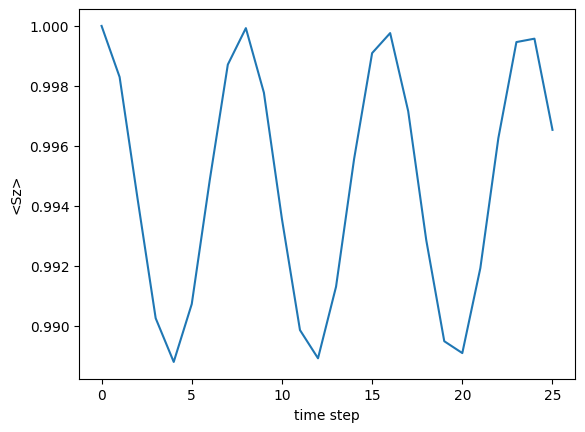

In [15]:
plt.plot(Szs)
plt.xlabel('time step')
plt.ylabel('<Sz>')
plt.show()